# Find Classwise Accuracy

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
#tf.enable_eager_execution()

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sklearn

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

tf.random.set_random_seed(13)

import py3nvml
py3nvml.grab_gpus(1)

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passi

1

In [2]:
multi_step = True
num_predicted_steps = 10
model_path = "trained_models_acc/multistep/LSTM3_10steps_small.h5"

# Load the dataset

In [3]:
dataset = np.load('../data/acc/compressed/full_data.npy')
print("Before: ", dataset.shape)
#Swap axes
dataset = dataset.swapaxes(1, -1)

#Combine station and xyz
#dataset = dataset.reshape(dataset.shape[0], dataset.shape[1], -1)
print("After: ", dataset.shape)

Before:  (35679, 15, 60)
After:  (35679, 60, 15)


In [4]:
def shuffle(x):
    ## Shuffle together two arrays of the exact same dimensions
    idxs = np.arange(x.shape[0])
    np.random.seed(10)
    np.random.shuffle(idxs)
    x = x[idxs]
    return x

dataset = shuffle(dataset)

In [5]:
data_mean = np.mean(dataset, axis = 1)
data_var = np.linalg.norm(dataset - np.expand_dims(data_mean, 1), axis = 1)

#Add some epsilon to make the divide by zero var work
epsilon = 1
data_var[data_var == 0] = epsilon

dataset = (dataset - np.expand_dims(data_mean, 1))/np.expand_dims(data_var, 1)

In [6]:
def multivariate_data(dataset, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []
    
    start_index = history_size
    end_index = dataset.shape[1] - target_size
        
    for quake in dataset:

        for i in range(start_index, end_index):
            indices = range(i-history_size, i, step)
            data.append(quake[indices])

            if single_step:
                labels.append(quake[i+target_size])
            else:
                labels.append(quake[i:i+target_size])

    return np.array(data), np.array(labels)

In [7]:
TRAIN_SPLIT_IDX = int(dataset.shape[0]*0.8)
val_dataset = dataset[TRAIN_SPLIT_IDX:]
val_data_mean = data_mean[TRAIN_SPLIT_IDX:]
val_data_var = data_var[TRAIN_SPLIT_IDX:]

val_dataset.shape

(7136, 60, 15)

In [8]:
past_history = 15
STEP = 1

x, y = multivariate_data(val_dataset,past_history,
                                                   num_predicted_steps, STEP,
                                                   single_step=not multi_step)

x.shape, y.shape

((249760, 15, 15), (249760, 10, 15))

# Load the model

In [9]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(128,
                                          return_sequences=True,
                                          input_shape=x.shape[-2:]))
single_step_model.add(tf.keras.layers.LSTM(64, return_sequences=True, activation='relu'))
single_step_model.add(tf.keras.layers.LSTM(64, activation='relu'))
single_step_model.add(tf.keras.layers.Dense(15*num_predicted_steps))

single_step_model.load_weights(model_path)

single_step_model.compile(optimizer='nadam', loss='mae', metrics=['mae', 'mse'])
single_step_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 128)           73728     
_________________________________________________________________
lstm_1 (LSTM)                (None, 15, 64)            49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 150)               9750      
Total params: 165,910
Trainable params: 165,910
Non-trainable params: 0
_________________________________________________________________


In [10]:
y_pred = single_step_model.predict(x, batch_size = 4096).reshape(y.shape)

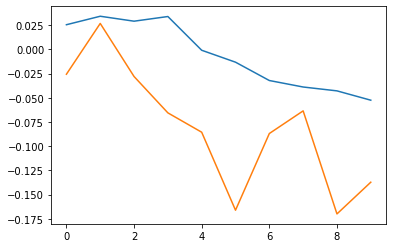

In [11]:
num = 1221
plt.plot(y_pred[num, :, 0])
plt.plot(y[num, :, 0])

In [12]:
y_pred.shape, y.shape, len(val_dataset)

((249760, 10, 15), (249760, 10, 15), 7136)

In [13]:
#Optional, if multistep then take last one
if num_predicted_steps > 1:
    y_pred = y_pred[:, -1, :]
    #y_pred = y_pred[:, 0, :] # Or the first one, for 1 second preds
    y = y[:, -1, :]
    
y_pred.shape, y.shape, len(val_dataset)

((249760, 15), (249760, 15), 7136)

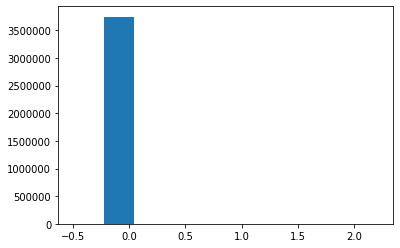

In [14]:
def recover_quake(y_pred, y, means, norms, num_quakes):
    y_pred = y_pred.reshape((num_quakes, -1, 15))
    y = y.reshape((num_quakes, -1, 15))
    
    y = y*np.expand_dims(norms, 1) + np.expand_dims(means, 1)
    y_pred = y_pred*np.expand_dims(norms, 1) + np.expand_dims(means, 1)

    return y, y_pred, (y - y_pred).reshape((-1,))

og_y, og_y_pred, delta = recover_quake(y_pred, y, val_data_mean, val_data_var, len(val_dataset))

plt.figure()
plt.hist(delta)
plt.show()

In [15]:
y.shape

(249760, 15)

In [16]:
def mae(delta):
    return np.mean(np.abs(delta))
mae(delta)

0.00012789518478828832

In [17]:
mae(delta)/np.mean(val_data_var)

0.05700611642619378

In [18]:
from sklearn import metrics

for y_true, y_pred in [(y, y_pred)]:
    print()
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    print("Explained Variance Score:", metrics.explained_variance_score(y_true, y_pred)) 
    print("Max Error Score:", metrics.max_error(y_true, y_pred)) 
    print("Mean Absolute Error Score:", metrics.mean_absolute_error(y_true, y_pred)) 
    print("Mean Squared Error Score:", metrics.mean_squared_error(y_true, y_pred)) 
    print("Median Absolute Error Score:", metrics.median_absolute_error(y_true, y_pred)) 
    print("R2 Score:", metrics.r2_score(y_true, y_pred)) 


Explained Variance Score: 0.2562019267463558
Max Error Score: 1.0381451705448637
Mean Absolute Error Score: 0.06409451428452746
Mean Squared Error Score: 0.012306031519768782
Median Absolute Error Score: 0.030708762709805874
R2 Score: 0.2327803145302869


# Alert accuracy

In [29]:
#MMI accel cutoffs (m/s^2) 
#              I,  II/III  IV        V      VI      VII       VIII      IX    X+
MMI_cutoffs = [    0.01667, 0.13729, 0.38246, 0.90221, 1.76520, 3.33426, 6.37432, 12.16025]

In [20]:
og_MMI = np.searchsorted(MMI_cutoffs, og_y.reshape(-1), side = 'right')
og_MMI_pred = np.searchsorted(MMI_cutoffs, og_y_pred.reshape(-1), side = 'right')
print(og_y.shape, og_y_pred.shape, og_MMI.shape, og_MMI_pred.shape)

(7136, 35, 15) (7136, 35, 15) (3746400,) (3746400,)


In [21]:
np.unique(og_MMI, return_counts = True), np.unique(og_MMI_pred, return_counts = True)

((array([0, 1, 2, 3, 4, 5]),
  array([3741532,    4218,     424,     192,      27,       7])),
 (array([0, 1, 2, 3, 4]),
  array([3742437,    3428,     411,     119,       5])))

[0, 1, 2, 3, 4, 5]


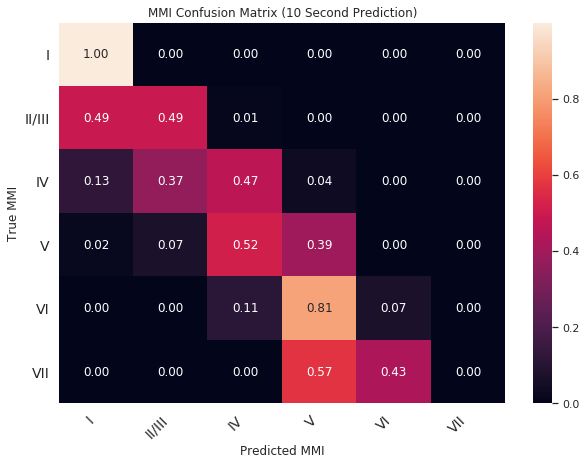

In [22]:
def print_confusion_matrix(confusion_matrix, class_names = None, figsize = (10,7), fontsize=14, labels=None, title=None):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    sns.set(font_scale=1)
    if class_names == None:
        class_names = list(np.arange(len(confusion_matrix)))
        
    print(class_names)
    
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')
    
    if labels:
        heatmap.yaxis.set_ticklabels(labels, rotation=0, ha='right', fontsize=fontsize)
        heatmap.xaxis.set_ticklabels(labels, rotation=45, ha='right', fontsize=fontsize)
    else:
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True MMI')
    plt.xlabel('Predicted MMI')
    if title != None:
        plt.title(title)
    return fig

cmat = metrics.confusion_matrix(og_MMI, og_MMI_pred)
cmat = cmat / np.expand_dims(np.sum(cmat, axis = 1), 1)
print_confusion_matrix(cmat, labels=["I", "II/III", "IV", "V", "VI", "VII", "VIII", "IX", "X+"], title="MMI Confusion Matrix (10 Second Prediction)");

In [23]:
alert_thresh = 3  #MMI V
fpr = np.mean(og_MMI_pred[og_MMI < alert_thresh] >= alert_thresh)
fnr = np.mean(og_MMI_pred[og_MMI >= alert_thresh] < alert_thresh)
fpr, fnr

(4.8049022816345425e-06, 0.5309734513274337)

In [24]:
# Make a F1 Curve
decision_threshes = np.linspace(0, 0.01, 1001)
alert_thresh = 0.38246
sens = []
spec = []
for decision_thresh in decision_threshes:
    sens.append(np.mean(og_y_pred.reshape(-1)[og_y.reshape(-1) >= alert_thresh] >= decision_thresh))
    spec.append(np.mean(og_y_pred.reshape(-1)[og_y.reshape(-1) < alert_thresh] < decision_thresh))
    
sens = np.array(sens)
spec = np.array(spec)
sens, spec

(array([1.        , 1.        , 1.        , ..., 0.99557522, 0.99557522,
        0.99557522]),
 array([0.00877802, 0.23935701, 0.46738432, ..., 0.99810527, 0.9981074 ,
        0.99810954]))

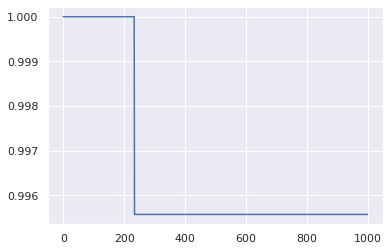

In [25]:
plt.plot(sens)

0.9693080004724101


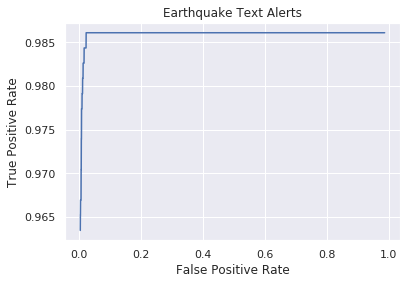

In [54]:
plt.title("Earthquake Text Alerts")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.plot(1-spec, sens)

print(sklearn.metrics.auc(1-spec, sens))

EER:  0.9961907802467264 0.995575221238938


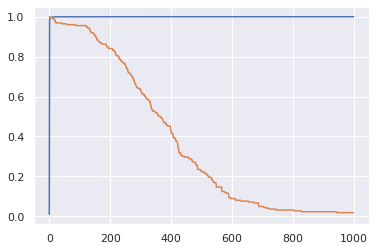

In [28]:
#Find EER
temp = spec > sens
print("EER: ", spec[np.argmax(temp)], sens[np.argmax(temp)])
plt.plot(spec)
plt.plot(sens)

# Molchan time!
We will draw Molchan curves, one line for every time offset, with the line parameterized by additional margin

/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


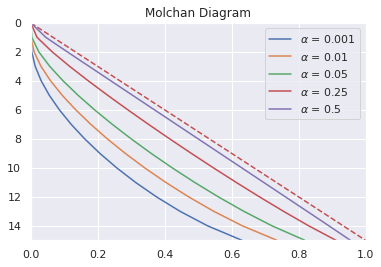

In [29]:
#python version of above equation
from scipy.special import comb
from scipy.optimize import fsolve

def func(a, N, h, tau):
    out = 0
    for i in range(h, N+1):
        out += comb(N, i) * (tau**i) * (1-tau)**(N-i)
        
    return out - a

#Solves for one tau
def get_tau(a, N, h):
    sfunc = lambda tau : func(a, N, h, tau)
    
    x = np.arange(0, 1, 0.01)
    y = np.array([sfunc(datum) for datum in x])
    init_guess = np.argmax(y > 0)/100
    
    return fsolve(sfunc, init_guess)

#Gives all the taus
def get_taus(a, N, h):
    taus = np.zeros(h.shape)
    
    for i in range(len(h)):
        taus[i] = get_tau(a, N, i)
        
    return taus
        
#Plots a molchan
def plot_molchan(N):
    h = np.arange(N+1)
    
    plt.figure()
    plt.plot(np.linspace(0, 1, 10), np.linspace(0, N, 10), 'r--')
    for a in [0.001, 0.01, 0.05, 0.25, 0.50]:
        plt.plot(get_taus(a, N, h), h, label=r'$\alpha$ = ' + str(a))
    plt.xlim([0, 1])
    plt.ylim([N, 0])
    plt.legend()
    plt.title("Molchan Diagram")
    plt.show()
    
plot_molchan(15)

In [30]:
time_offsets = np.arange(10)
margins = np.linspace(-100, 40, 101)
time_offsets, margins

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([-100. ,  -98.6,  -97.2,  -95.8,  -94.4,  -93. ,  -91.6,  -90.2,
         -88.8,  -87.4,  -86. ,  -84.6,  -83.2,  -81.8,  -80.4,  -79. ,
         -77.6,  -76.2,  -74.8,  -73.4,  -72. ,  -70.6,  -69.2,  -67.8,
         -66.4,  -65. ,  -63.6,  -62.2,  -60.8,  -59.4,  -58. ,  -56.6,
         -55.2,  -53.8,  -52.4,  -51. ,  -49.6,  -48.2,  -46.8,  -45.4,
         -44. ,  -42.6,  -41.2,  -39.8,  -38.4,  -37. ,  -35.6,  -34.2,
         -32.8,  -31.4,  -30. ,  -28.6,  -27.2,  -25.8,  -24.4,  -23. ,
         -21.6,  -20.2,  -18.8,  -17.4,  -16. ,  -14.6,  -13.2,  -11.8,
         -10.4,   -9. ,   -7.6,   -6.2,   -4.8,   -3.4,   -2. ,   -0.6,
           0.8,    2.2,    3.6,    5. ,    6.4,    7.8,    9.2,   10.6,
          12. ,   13.4,   14.8,   16.2,   17.6,   19. ,   20.4,   21.8,
          23.2,   24.6,   26. ,   27.4,   28.8,   30.2,   31.6,   33. ,
          34.4,   35.8,   37.2,   38.6,   40. ]))

In [31]:
past_history = 15
STEP = 1

x, y = multivariate_data(val_dataset,past_history,
                                                   num_predicted_steps, STEP,
                                                   single_step=not multi_step)

y_pred = single_step_model.predict(x, batch_size = 4096).reshape(y.shape)
y.shape, y_pred.shape

((249760, 10, 15), (249760, 10, 15))

In [32]:
molchan_tau = []
molchan_tpr = []
for offset in time_offsets:
    curr_tau = []
    curr_tpr = []

    curr_y, curr_y_pred, delta = recover_quake(y_pred[:, offset, :], 
                                             y[:, offset, :], 
                                             val_data_mean, 
                                             val_data_var, 
                                             len(val_dataset))
    
    curr_MMI = np.searchsorted(MMI_cutoffs, curr_y.reshape(-1), side = 'right')

    for margin in margins:
        curr_MMI_pred = np.searchsorted(MMI_cutoffs, curr_y_pred.reshape(-1) + margin, side = 'right')
        sens = np.mean(curr_MMI_pred[curr_MMI >= alert_thresh] >= alert_thresh)
        tau = np.mean(curr_MMI_pred >= alert_thresh)
        curr_tpr.append(sens)
        curr_tau.append(tau)
        
    molchan_tau.append(curr_tau)
    molchan_tpr.append(curr_tpr)
molchan_tau = np.array(molchan_tau)
molchan_tpr = np.array(molchan_tpr)
molchan_tau = np.concatenate((np.zeros((10, 1)), molchan_tau), axis = 1)
molchan_tpr = np.concatenate((np.zeros((10, 1)), molchan_tpr), axis = 1)
molchan_tau, molchan_tpr

(array([[0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        ...,
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.]]), array([[0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        ...,
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.]]))

(0, 1)

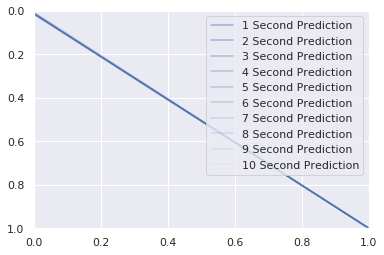

In [33]:
for i in time_offsets:
    plt.plot(molchan_tau[i], molchan_tpr[i], color = 'b', alpha = 0.5 - 0.05*i, label = str(i+1) + " Second Prediction")
plt.legend()
plt.ylim([1, 0])
plt.xlim([0, 1])

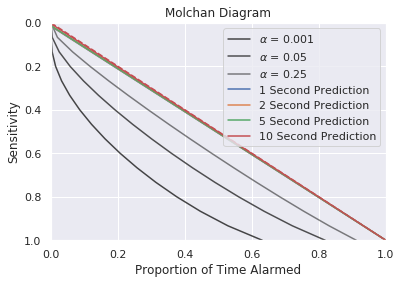

In [34]:
#Plots a result molchan
def plot_molchan_result(tau, tpr, time_offsets, N = 15):
    h = np.arange(N+1)
    
    plt.figure()
    
    #Plot significance thresholds
    plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), 'r--')
    for a in [0.001, 0.05, 0.25]:
        plt.plot(get_taus(a, N, h), h/N, color = 'k', alpha = 0.8 - a, label=r'$\alpha$ = ' + str(a))
        
    for i in range(len(time_offsets)):
        plt.plot(tau[i], tpr[i], color = 'C' + str(i), label = str(time_offsets[i]+1) + " Second Prediction")
        
    plt.xlim([0, 1])
    plt.ylim([1, 0])
    plt.ylabel("Sensitivity")
    plt.xlabel("Proportion of Time Alarmed")
    plt.legend()
    plt.title("Molchan Diagram")
    plt.show()
    
idxs = [0, 1, 4, 9]
plot_molchan_result(molchan_tau[idxs], molchan_tpr[idxs], time_offsets[idxs])

# Alert Latency

In [45]:
# Find the time from origin it takes for the model to predict
large_quake_idxs = np.nonzero(np.max(np.max(og_y, axis = -1), axis=-1) > MMI_cutoffs[1])
large_quakes = og_y[large_quake_idxs]
large_quakes_pred = og_y_pred[large_quake_idxs]
large_quake_idxs

(array([ 193,  299,  353,  444,  840,  936,  981, 1130, 1757, 2033, 2880,
        2976, 3003, 3703, 4027, 4075, 5132, 5385, 5810, 5921, 6165, 6250,
        6305, 6310, 6445, 6683]),)

Quake 0


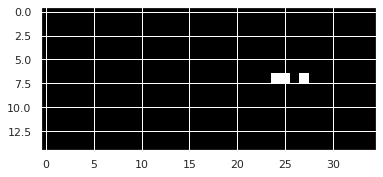

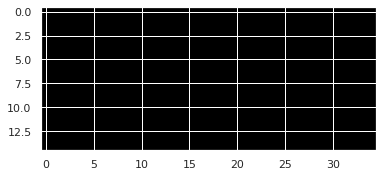

Quake 1


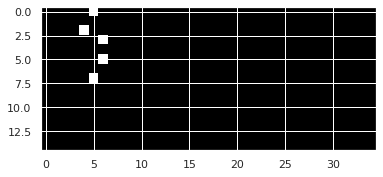

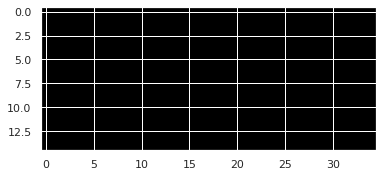

Quake 2


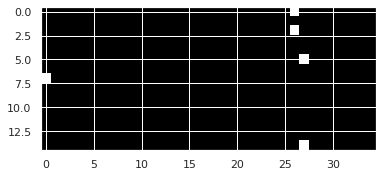

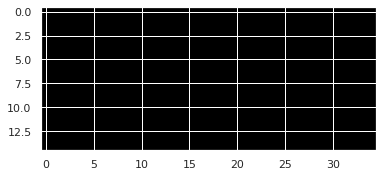

Quake 3


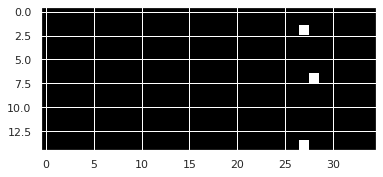

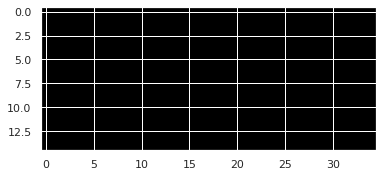

Quake 4


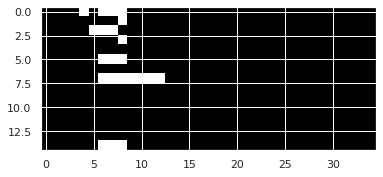

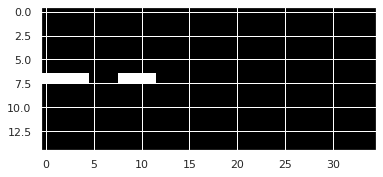

Quake 5


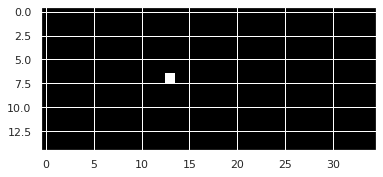

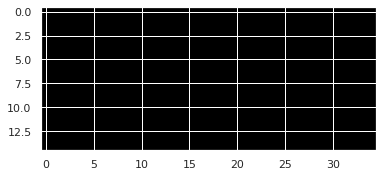

Quake 6


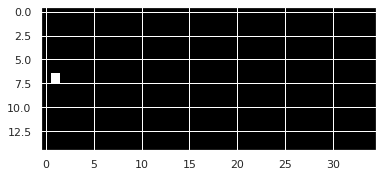

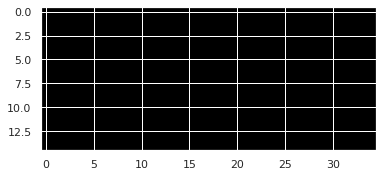

Quake 7


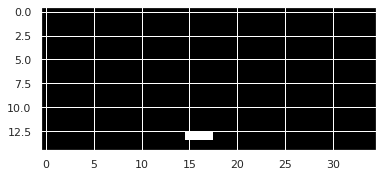

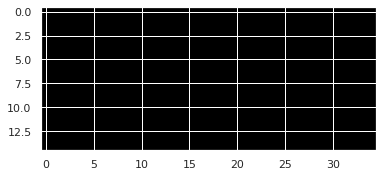

Quake 8


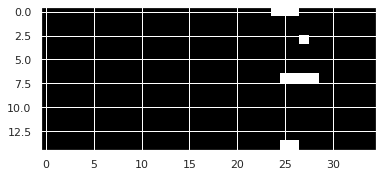

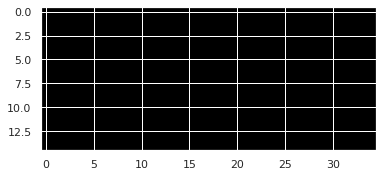

Quake 9


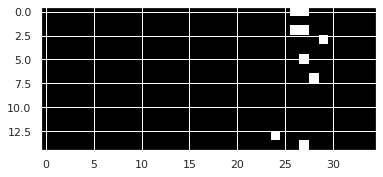

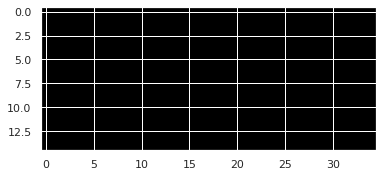

Quake 10


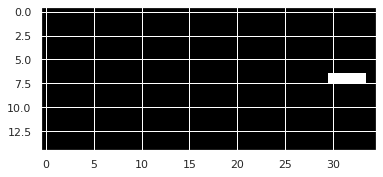

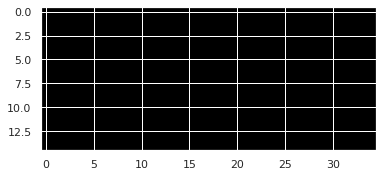

Quake 11


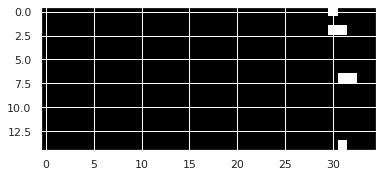

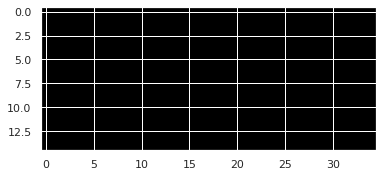

Quake 12


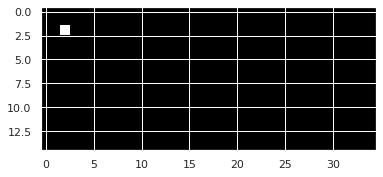

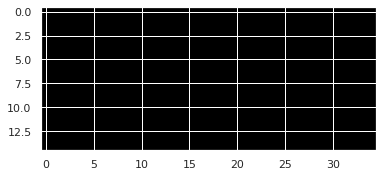

Quake 13


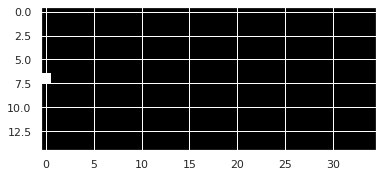

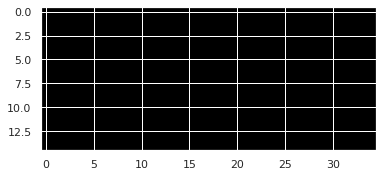

Quake 14


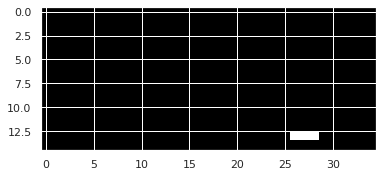

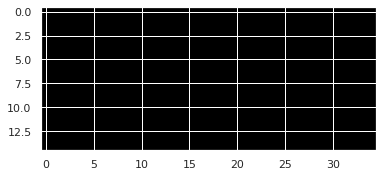

Quake 15


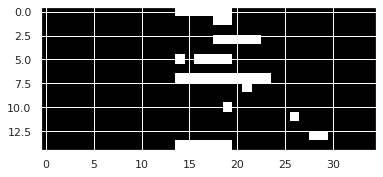

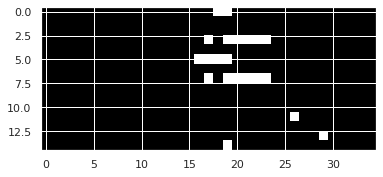

Quake 16


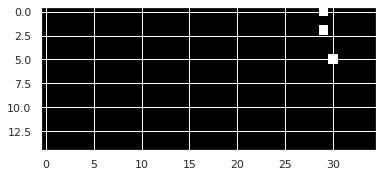

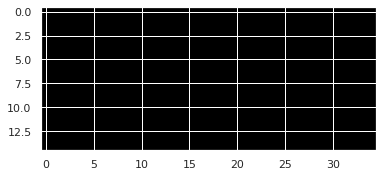

Quake 17


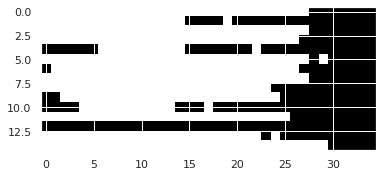

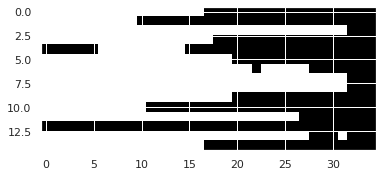

Quake 18


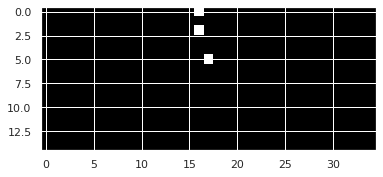

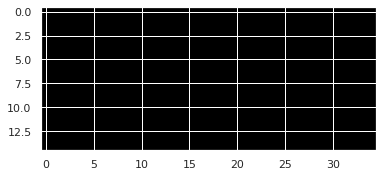

Quake 19


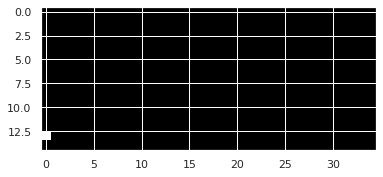

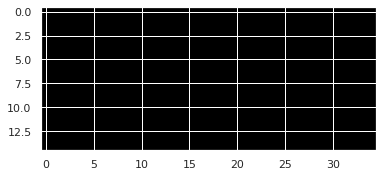

Quake 20


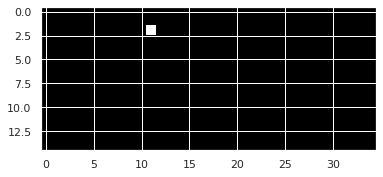

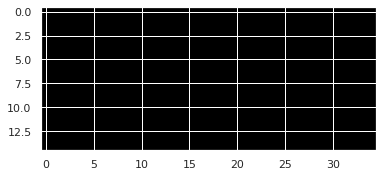

Quake 21


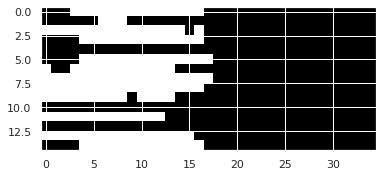

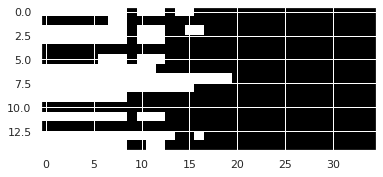

Quake 22


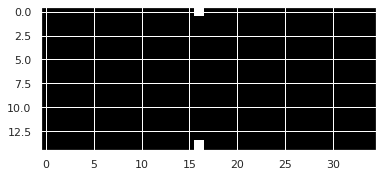

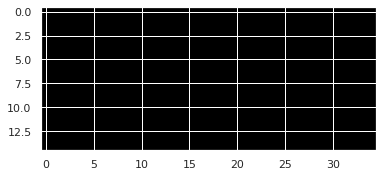

Quake 23


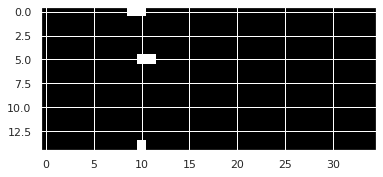

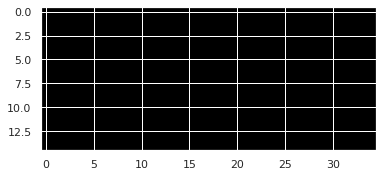

Quake 24


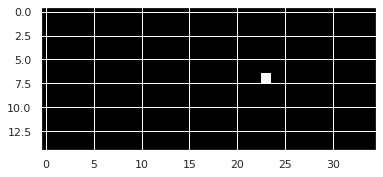

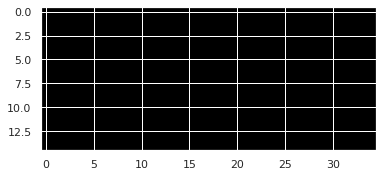

Quake 25


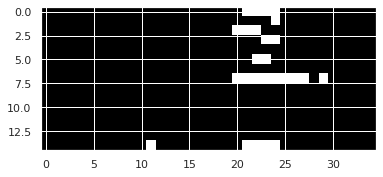

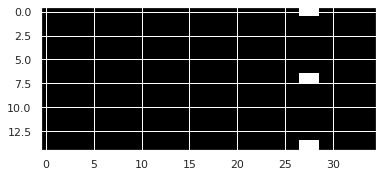

In [57]:
for i, quake, quake_pred in zip(range(len(large_quakes)), large_quakes, large_quakes_pred):
    print("Quake", i)
    plt.figure()
    plt.imshow(quake.T > MMI_cutoffs[1], interpolation='none', cmap='gray')
    plt.show()
    plt.figure()
    plt.imshow(quake_pred.T > MMI_cutoffs[1], interpolation='none', cmap='gray')
    plt.show()

# Peak Deviation

In [ ]:
deviation = np.abs(np.max(og_y, axis = (-1, -2)) - np.max(og_y_pred, axis=(-1, -2)))
plt.hist(deviation)